In [76]:
import pandas as pd
from datetime import datetime
import numpy as np
import networkx as nx
import community.community_louvain as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt


In [ ]:
time_interval = '15T' # we group trades on 15 minutes intervals
N = 50 # number of days
T = 300 # number of stocks

Load the train and val files, merge them, keep only data before 4pm and add a log return column

In [85]:

train_file = f"data/train_data_N{N}_T{T}_2012.parquet"
val_file = f"data/val_data_N{N}_T{T}_2012.parquet"
train_df = pd.read_parquet(train_file)
val_df = pd.read_parquet(val_file)

combined_df = pd.concat([train_df, val_df], ignore_index=True)

time_threshold = "16:00"
time_limit = pd.to_datetime(time_threshold, format="%H:%M").time()
filtered_df = combined_df[combined_df['Time_of_day'] <= time_limit]
filtered_df["Date"] = filtered_df["Timestamp"].dt.date

filtered_df['log-return'] = np.log(filtered_df['trade-price']).diff()
filtered_df = filtered_df.dropna(subset=['log-return'])
filtered_df.head()

C:\Users\phlev\AppData\Local\Temp\ipykernel_143660\3774526623.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Date"] = filtered_df["Timestamp"].dt.date
C:\Users\phlev\AppData\Local\Temp\ipykernel_143660\3774526623.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['log-return'] = np.log(filtered_df['trade-price']).diff()


,trade-price,trade-volume,trade-stringflag,Timestamp,Stock,Time_of_day,Before_16:00,Date,log-return
1,43.71,256,uncategorized,2012-07-02 14:12:49.629,XLY.P,14:12:49.629000,True,2012-07-02,0.008732
2,46.97,1300,uncategorized,2012-12-06 15:27:27.101,XLY.P,15:27:27.101000,True,2012-12-06,0.071932
3,47.78,400,uncategorized,2012-09-14 13:51:16.766,XLY.P,13:51:16.766000,True,2012-09-14,0.017098
4,45.87,500,uncategorized,2012-10-31 15:14:01.693,XLY.P,15:14:01.693000,True,2012-10-31,-0.040796
5,40.02,300,uncategorized,2012-01-13 15:21:22.710,XLY.P,15:21:22.710000,True,2012-01-13,-0.136432


Create the dataframe: basically a table with each columns as days, each row as a stock logreturn on a designated interval

In [ ]:

filtered_df['Floored_Timestamp'] = filtered_df['Timestamp'].dt.floor(time_interval) # Floor the timestamp to the nearest time_interval minutes
# add a column with stock and new timestamp for merging
filtered_df['Stock_Timestamp'] = filtered_df['Stock'] + "_" + filtered_df['Floored_Timestamp'].dt.strftime('%H:%M:%S')

grouped_df = filtered_df.pivot_table(index='Stock_Timestamp', columns='Date', values='log-return', aggfunc='mean')
grouped_df = grouped_df.fillna(0)

print(grouped_df.shape)
grouped_df


In [ ]:
#create correlation dataframe between days
corr = grouped_df.corr()
corr.head()

Date,2012-01-03,2012-01-04,2012-01-05,2012-01-06,2012-01-09,2012-01-10,2012-01-11,2012-01-12,2012-01-13,2012-01-17,...,2012-12-17,2012-12-18,2012-12-19,2012-12-20,2012-12-21,2012-12-24,2012-12-26,2012-12-27,2012-12-28,2012-12-31
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,1.000000,0.818279,0.666000,0.650529,0.586553,0.704311,0.666969,0.676193,0.654016,0.599712,...,-0.084857,-0.234637,-0.255237,-0.100227,-0.197237,-0.161948,-0.147452,-0.231320,-0.233876,-0.185119
2012-01-04,0.818279,1.000000,0.788476,0.800287,0.718294,0.777452,0.754825,0.747917,0.738600,0.697890,...,-0.166543,-0.296564,-0.291737,-0.157752,-0.251667,-0.229083,-0.236958,-0.298281,-0.310424,-0.267190
2012-01-05,0.666000,0.788476,1.000000,0.750967,0.743833,0.809421,0.711817,0.621950,0.696786,0.669886,...,-0.234068,-0.323497,-0.214431,-0.192277,-0.303416,-0.251588,-0.245777,-0.211468,-0.330716,-0.301487
2012-01-06,0.650529,0.800287,0.750967,1.000000,0.877237,0.790971,0.748834,0.650469,0.686746,0.669941,...,-0.230567,-0.314894,-0.322092,-0.218770,-0.255763,-0.267543,-0.327244,-0.358323,-0.234024,-0.338819
2012-01-09,0.586553,0.718294,0.743833,0.877237,1.000000,0.755524,0.684070,0.592348,0.656723,0.717259,...,-0.279132,-0.339987,-0.256025,-0.210473,-0.286308,-0.300709,-0.331791,-0.280441,-0.255788,-0.374105


In [80]:

def get_sortest_eig(C):
    '''
    input 
        C: correlation matrix
        
    output: 
        l: eigenvalues
        v: eigenvectors 
    '''
    
    l,v = np.linalg.eigh(C)
    ordn = np.argsort(l)
    l,v = l[ordn],v[:,ordn]
    return l,v

l, v = get_sortest_eig(corr)

lambda_limit = 1e-1
len(l[l<lambda_limit]) 
selected_indices = [i for i, l in enumerate(l) if l <= lambda_limit]

C_r = np.zeros_like(corr)

for i in selected_indices:
    v_i = v[:, i]  # Get the i-th eigenvector
    outer_product = np.outer(v_i, v_i)  # Compute outer product
    C_r += l[i] * outer_product  # Add scaled matrix to the sum

C_m = l[-1] * np.outer(v[-1, :],v[-1, :])
C_0 = C_r + C_m
C = abs(corr - C_0)
G = nx.from_pandas_adjacency(C)


In [81]:
partition = community_louvain.best_partition(G)
print(len(partition))
print(partition)

250
{datetime.date(2012, 1, 3): 2, datetime.date(2012, 1, 4): 2, datetime.date(2012, 1, 5): 2, datetime.date(2012, 1, 6): 2, datetime.date(2012, 1, 9): 2, datetime.date(2012, 1, 10): 2, datetime.date(2012, 1, 11): 2, datetime.date(2012, 1, 12): 2, datetime.date(2012, 1, 13): 2, datetime.date(2012, 1, 17): 2, datetime.date(2012, 1, 18): 2, datetime.date(2012, 1, 19): 2, datetime.date(2012, 1, 20): 2, datetime.date(2012, 1, 23): 2, datetime.date(2012, 1, 24): 2, datetime.date(2012, 1, 25): 2, datetime.date(2012, 1, 26): 2, datetime.date(2012, 1, 27): 2, datetime.date(2012, 1, 30): 2, datetime.date(2012, 1, 31): 2, datetime.date(2012, 2, 1): 2, datetime.date(2012, 2, 2): 2, datetime.date(2012, 2, 3): 2, datetime.date(2012, 2, 6): 2, datetime.date(2012, 2, 7): 2, datetime.date(2012, 2, 8): 2, datetime.date(2012, 2, 9): 2, datetime.date(2012, 2, 10): 2, datetime.date(2012, 2, 13): 2, datetime.date(2012, 2, 14): 2, datetime.date(2012, 2, 15): 2, datetime.date(2012, 2, 16): 2, datetime.date(2

In [82]:
# Convert partition to a dataframe
partition_df = pd.DataFrame(list(partition.items()), columns=['Date', 'Cluster'])

# Merge log return data with cluster assignments
log_return_clustered = filtered_df.merge(partition_df, on='Date')
log_return_clustered.groupby('Cluster')["log-return"].sum()


Cluster
0    -4543.915286
1   -19482.085959
2    24024.819411
Name: log-return, dtype: float64

In [83]:
# how many clusters
num_clusters = len(set(partition.values()))
num_clusters

3

C:\Users\phlev\AppData\Local\Temp\ipykernel_143660\1841700985.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', max(partition.values()) + 1)


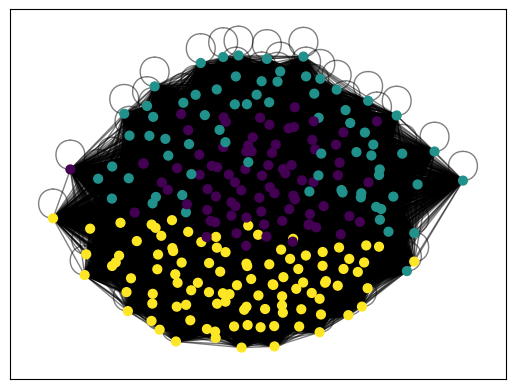

In [84]:
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()